## Impacts of lockdown restrictions on the ambient population of Leeds City Centre - analysis of footfall cameras


The following notebook is an analysis of the [Leeds City Council Footfall Camera data](https://datamillnorth.org/dataset/leeds-city-centre-footfall-data) over the period of various lockdown restrictions across 2020 and 2021.  It attempts to answer the question <i>"what has the impact of lockdown policies been on footfall in Leeds city centre?”</i>


If viewing in a notebook browser window, the Plotly charts may not show unless everything is rerun from the toolbar at the top.

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import sys
import pandas as pd
import numpy as np
from IPython.display import HTML
import datetime

from plotly.subplots import make_subplots

sys.path.append("..")  # Tell python to search parent directory when looking for 'source.py'
from source import *

### Importing the data

The imported data below was created from a function that runs through each csv, creates a dataframe for each and then merges them.  Columns are converted to appropriate data types and any mismatches are fixed before merging.  This is important as Leeds City Council changed the formats of the files several times, which led to some differences in column names and potentially data types.

In [2]:
#import merged footfall data
footfalldf_imported = pd.read_csv("../data/footfall_merged.csv.gz",
                                  parse_dates=['Date','DateTime'],
                                  dtype={"BRCYear": int,"BRCWeekNum":int})

### Cleaning the data
The next step in the pipeline is to check for duplicates and remove them.  Initial data exploration revealed errors in some of the csv files where individual records had been duplicated.  In some instances, the same records existed in several different files, for example dates in early July appeared towards the end of the June csv.

The cameras don't all come online at the same time, with the last starting on 27th August 2008.  To ensure meaningful comparability, any records before this date have been removed.

Finally, one of the cameras appeared to have moved locations on 31st May 2015 from Commercial Street at Lush to Commercial Street at Sharps.  These are combined and renamed to Commercial Street Combined.

In [3]:
#Pipeline that imports csv files, creates a dataframe and applies cleaning functions
footfalldf = (footfalldf_imported
              .pipe(start_pipeline)
              .pipe(set_start_date, '2008-08-27')
              .pipe(combine_cameras)
              .pipe(check_remove_dup)
              .pipe(create_BRC_MonthNum))

#Useful list for if months ever lost when resampling or plotting.
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

Footfall hasn't changed when combining cameras
There are 0 duplicates left


### Cleaned dataset

This analysis is also part of another workflow to provide a combined, cleaned dataset from the individual files.  Whilst the code to achieve this still needs some adjustments and thresholds need to be agreed on, the visualisations in this notebook have been produced from a dataset that has already been thoroughly investigated and cleaned.

### Footfall in Leeds City Centre - high level overview

The bar charts below show mean hourly footfall over each month for 2019, 2020 and 2021.  Initially visualising the data like this has helped to identify gaps in the data so creating a cleaner dataset for analysis.  It also provides a useful high level overview of the impacts of lockdown on footfall in Leeds City Centre over most of 2020 and all 2021 compared to 'business as usual' in 2019.  The immediate drop in March after restrictions were implemented is just one indication of the impacts, felt throughout the year as shown by the variation in height of the bars.

Where possible, British Retail Consortium (BRC) frequencies have been used to subset and analyse the data, rather than extracting them directly from the DateTime field.  This allowed sense checks to be undertaken against the official Springboard reports during analysis.

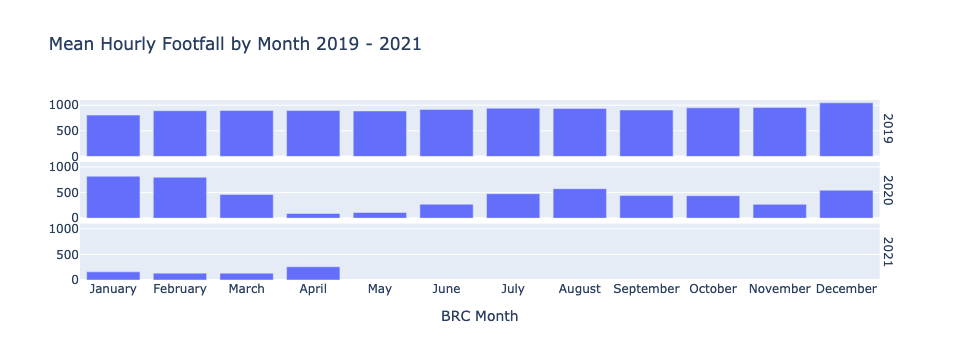

In [4]:
data_18to20 = footfalldf.loc[footfalldf.BRCYear >= 2019]
data_18to20 = mean_hourly(data_18to20,"month")

fig = px.bar(data_18to20,
             x='BRCMonth',y='Count',title="Mean Hourly Footfall by Month 2019 - 2021",
             facet_row='BRCYear',
             category_orders={"BRCYear": [2019,2020,2021],
                              "BRCMonth": Months},
             labels={"Count": "","BRCMonth": "BRC Month"})
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()

With such a clear contrast to 2019 established, the next step of the analysis was to look at the lockdown period specifically.  Since the pandemic hit so early on in 2020, the entire year is included in most of the analysis except for the change from baseline later on.

### Identifying artifacts

First, the data was aggregated to daily frequency and the mean hourly footfall for each day was calculated and plotted below.  The chart has been split out by location to identify whether any specific trends in the data occurred homogenously across the city centre.  Previous analysis has at LIDA has identified gaps or artifacts which might lead to distorted visualisations if not corrected for.

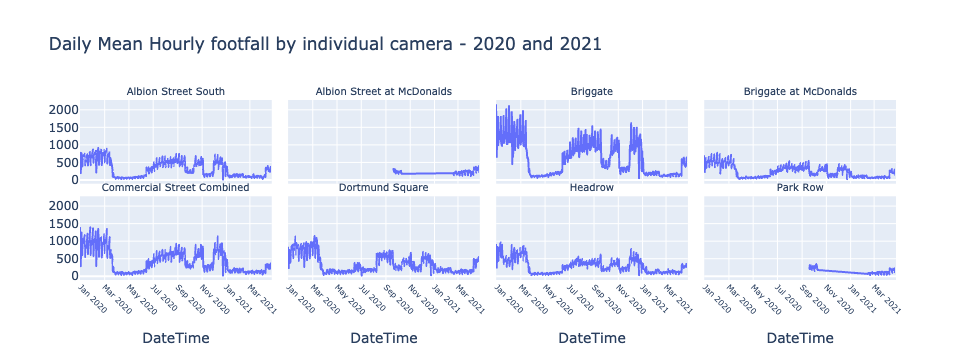

In [5]:
data_lockdown_location = (footfalldf
        .pipe(start_pipeline)
        .pipe(mean_hourly_location,"day")
        .pipe(reset_df_index)
        .pipe(set_dt_index)
        .pipe(set_lockdown_timeframe))

fig = px.line(data_lockdown_location,
                  title="Daily Mean Hourly footfall by individual camera - 2020 and 2021",
                  y='Count',
              facet_col='Location',facet_col_wrap=4,
                           labels={"Count": ""})
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1],
                                           font_size=10))

fig.update_xaxes(nticks=10, tickangle=45, tickfont=dict(size=8))

fig.show()

Interpretation of the lack of data from Albion Street at McDonalds and Park row is that they are relatively new cameras, coming online in September 2020.  Unfortunately, both appear to have large gaps between October 2020 and February 2021.  The decision was taken to drop these from the analysis so that the limited data they provide doesn't distort the footfall figures around the time of coming online and later in 2021.

In [6]:
#Removes Albion Street at McDonalds and Park row from the dataset.
footfalldf = (footfalldf
              .pipe(start_pipeline)
              .pipe(remove_new_cameras))

### Footfall across the City Centre
The following code creates three charts measuring daily footfall to be plotted later.  An explanation of these can be found underneath the code.

In [7]:
{
    "tags": [
        "hide-input",
    ]
}
#Create a pipeline to format the dataframe into mean hourly footfall by day and filter by 2020/2021.
data_lockdown = (footfalldf
                 .pipe(start_pipeline)
                 .pipe(mean_hourly, "day")
                 .pipe(reset_df_index)
                 .pipe(set_dt_index)
                 .pipe(set_lockdown_timeframe))

#Create plotly line chart object
mean_hourly_fig = px.line(data_lockdown,
              title="Daily Mean Hourly footfall 2020-2021",
              y='Count')

#format x axes ticks
mean_hourly_fig.update_xaxes(nticks=20, tickangle=45, tickfont=dict(size=8))

data_lockdown = (footfalldf
                 .pipe(start_pipeline)
                 .pipe(set_dt_index)
                 .pipe(set_lockdown_timeframe))

data_lockdown = data_lockdown.groupby( [pd.Grouper(level='DateTime',freq='D')])['Count'].sum()

total_fig = px.line(data_lockdown,
              title="Total Daily Footfall 2020-2021",
              y='Count')

total_fig.update_xaxes(nticks=20, tickangle=45, tickfont=dict(size=8))


#Pipeline to create dataframe with calculation of median of period 3rd January to March 5th
data_lockdown = (footfalldf
                 .pipe(start_pipeline)
                 .pipe(set_dt_index)
                 .pipe(set_lockdown_timeframe)
                 .pipe(calculate_baseline))

baseline_fig = px.line(data_lockdown,
              title="Daily Footfall 6th March 2020-2021 - % change from baseline",
              y='baseline_per_change',
            hover_data=['Day_Name','baseline_per_change'],
             labels={'DateTime': 'Date', 'Day_Name':'Day'})

baseline_fig.update_xaxes(nticks=20, tickangle=45, tickfont=dict(size=8))

pass #stops the chart displaying under this block.

The charts below show daily footfall for all cameras during 2020 and 2021.  The two measures used are mean hourly and total, both daily.  Using two measures allows potential issues with data, such as aggregation introducing values where missing data may be, to be picked up on.  If the trends around key lockdown dates show up in both charts, then they can be trusted more.

Key lockdown dates are shown in the table below the charts.  Red zones indicate where a full lockdown was in place whilst orange shows partial restrictions in place.

Plotly charts are interactive.  Should you wish, use the tools on the chart to pan and zoom for further investigation of specific time periods.

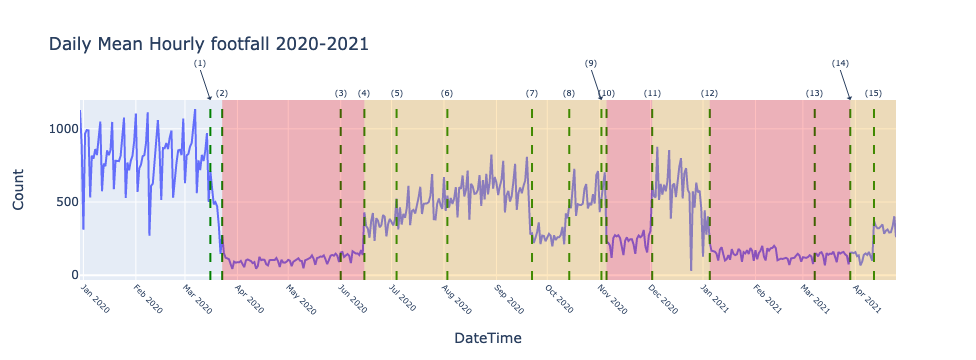

In [8]:
#Plot daily mean hourly footfall
chart_lockdown_dates(mean_hourly_fig).show()

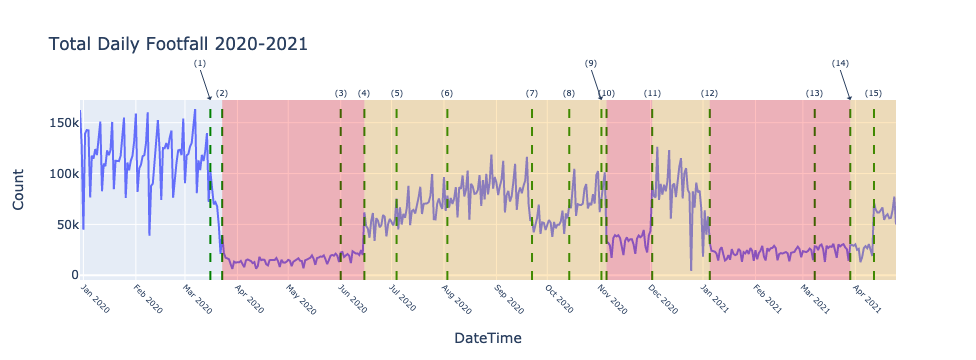

In [9]:
#Plot daily total footfall
chart_lockdown_dates(total_fig).show()


| Key | Date                | Description                                                                                  | Restrictions Implemented                                                                                            | Restrictions lifted                                                                                                                                                         |   |
|-----|---------------------|----------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|
|  1  | 16th March 2020     | Advice to stop non-essential contact and travel                                              | None - advice only                                                                                                  | None                                                                                                                                                                        |   |
|  2  | 20th March 2020     | Hospitality and leisure to close at midnight                                                 | Hospitality and leisure venues close                                                                                | None                                                                                                                                                                        |   |
|  3  | 23rd March 2020     | First lockdown announced                                                                     | Stay at Home, non-essential travel restricted, <br>non-essential retail and schools closed                          | None                                                                                                                                                                        |   |
|  4  | 10th May 2020       | Conditional lockdown easing announced, <br>working from home can be relaxed                  | None                                                                                                                | Partial return to workplaces if agreed with employer, <br>unlimited time outside, meet one person outside.                                                                  |   |
|  5  | 1st June 2020       | Phased reopening of primary schools                                                          | None                                                                                                                | Primary schools reopened, <br>groups of up to six meeting outside, Stay at Home.                                                                                            |   |
|  6  | 15th June 2020      | Non-essential retail and secondary schools reopen                                            | Face coverings mandatory on public transport                                                                        | Non-essential shops reopen. <br>Secondary schools reopen.                                                                                                                   |   |
|  7  | 3rd August 2020     | Eat out to Help out launched                                                                 | None                                                                                                                | Eat out to help out scheme                                                                                                                                                  |   |
|  8  | 22nd September 2020 | New restrictions in England, <br>including working from home and 10pm curfew for hospitality | Working from home, restrictions on hospitality.                                                                     | None                                                                                                                                                                        |   |
|  9  | 14th October 2020   | West Yorkshire put into tier 2                                                               | Mixing indoors outside of household/bubble banned, <br>rule of 6 outside. Pubs and bars only open if serving meals. | None                                                                                                                                                                        |   |
|  10 | 2nd November 2020   | 2nd Lockdown comes into force                                                                | All restrictions reimplemented                                                                                      | None                                                                                                                                                                        |   |
|  11 | 2nd December 2020   | 2nd Lockdown ends, tier system returns                                                       | None                                                                                                                | Restrictions eased in some areas.                                                                                                                                           |   |
|  12 | 5th January 2021    | 3rd Lockdown begins                                                                          | All restrictions reimplemented                                                                                      | None                                                                                                                                                                        |   |
|  13 | 8th March 2021      | 1st step of road out of lockdown - schools go back                                           | None                                                                                                                | Schools reopen                                                                                                                                                              |   |
|  14 | 29th March 2021     | 1st step out of lockdown - rule of 6 outdoors                                                | None                                                                                                                | Rule of 6 allowed outside, outdoors sports permitted, stay at home lifted                                                                                                   |   |
|  15 | 12th April 2021     | 2st step out of lockdown                                                                     | None                                                                                                                | Non-essential retail and hospitality (outdoors and self-contained accommodation only) reopen. Gyms and outdoor attractions reopen.  Funerals and weddings with more guests. |   |


Footfall starts to drop almost immediately after the announcement on 16th March that people should stop non-essential contact and travel.  This is four days before the intermediate 20th March restrictions on hospitality and a full week before the announcement of a full lockdown on 23rd March.  There's a stark contrast between the period of 'normality' in January and February and the sudden drop towards the end of March, with the relative variation between days of the week minimised to a large extent.

Footfall stays low, with a small increase as summer approaches, however it isn't until 15th June, when non-essential shops reopened, that a huge spike occurs.  More restrictions were eased on 4th July and footfall continues to rise into August.

One of the most high profile policies to have occured in 2020 was the Eat out to Help out scheme.  A government backed scheme launched on 3rd August, it gave people 50% discount on food and non-alcoholic drinks at participating outlets.  Business were able to claim the lost revenue back in an attempt to encourage people to help boost the hospitality sector after months of closure.  At the time of the launch, footfall was already steadily increasing so it's difficult to discern from the chart the exact impact of the scheme.  Additionally, it was only valid Monday to Wednesday.  A more granular analysis is undertaken later to tease out whether this had any impacts or not.

Another large drop comes after 22nd September when new restrictions are announced, although they noticably don't go back to first lockdown levels.  This lasts until an interesting spike around 14th October when the tier system comes into effect.  Leeds is put in tier 2, which bans mixing indoors outside of household/bubbles, a rule of 6 outside and hospitality can only open if serving full meals.  A second lockdown between 2nd November and 2nd December drives footfall down again but seemingly not to levels of the first lockdown.  Leeds is placed into tier 3, which all but prevents people from meeting in groups of 6 in a public place.  Hospitality remains closed and travel is restricted for all but essential purposes.

Christmas is a strange period, some days showing a significantly increased amount of footfall, most likely attributed to shopping at retail outlets.

Finally, the entire country is placed into tier 4, driving footfall down to similar levels seen in previous
lockdowns.

Another way to consider how footfall changes over the year is to look at percentage change from a baseline.  This baseline is the median value of each weekday between 3rd January and 5th March 2020, considered 'normal' conditions prior to announcements about avoiding social contact or travelling.

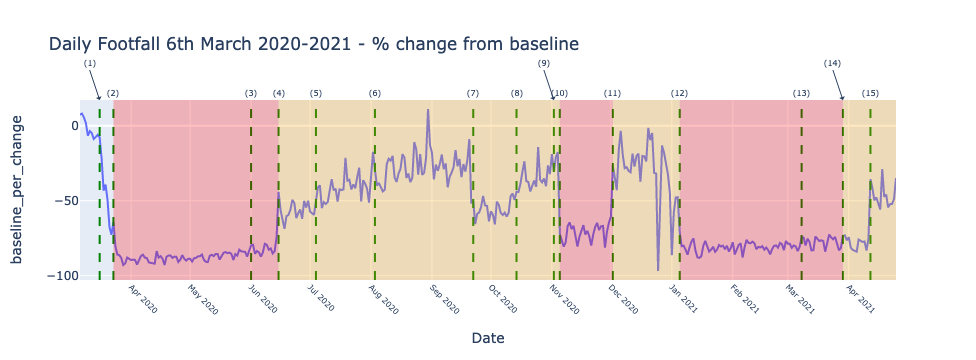

In [10]:
chart_lockdown_dates(baseline_fig).show()

Footfall has remained incredibly low compared to the baseline established from the start of the year.  Considering that this is essentially the middle to end of winter, it's fascinating to see that levels didn't really recover to pre-pandemic even over summer as the government eased restrictions.  Most days were still at least 10% lower than the baseline value.  This gap could be explained by employers choosing to keep offices closed or staffed to a minimum, combined with a wider caution from members of the public about leaving their local area.

Some of the outliers can most likely be explained according to the dates they happened on.  For example August 30th 2020 records approximately 11% higher than the baseline for a Sunday, the only instance of an increase in the whole dataset.  Most likely this is due to the August Bank Holiday, with restrictions at their loosest and the weather fairly good.

The lead up to Christmas is interesting.  Monday 21st and Tuesday 22nd have footfall representing less than a 10% and 5% decrease respectively from the baseline value.  This is most likely due to a combination of last minute Christmas shopping and people travelling through the city centre en route to wherever they were spending the festive period.  Considering that the government changed the Christmas rules on 19th December to only permit bubbles on 25th, there should be very little traffic through the city centre attributed to travelling long distances on public transport.

Previous research by Ross and Breckenridge (2021)[<sup>1</sup>](#fn1) suggests that mobility did not spike on Christmas day, as would be expected given the policy changes, but was more distributed over the withdrawn '5 day window' previously announced.

### Deeper Analysis - Key Lockdown Dates

Although the above chart is interactive, it still shows a very high level overview of the period of time since the start of lockdown.  Some of the key moments would benefit from a closer look over a small time period.

Given the similarities between footfall trends in all 3 measures explored above, the following charts will use mean hourly footfall.

#### Initial Restrictions

The first was the period around the start of lockdown, from 9th to 29th March 2020, when the government began to take action implementing nationwide restrictions.

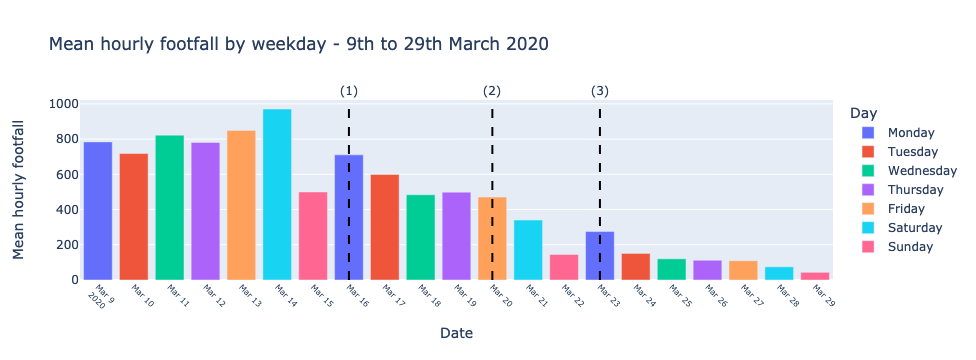

In [11]:
{
    "tags": [
        "hide-input",
    ]
}
#Chart fed by a pipeline to create dataframe grouped by days between 16th March 2020 - 22nd March 2020 and show mean hourly footfall.  Haven't figured out how to sort the colours dividing the days up yet!
data_2020_subset = (footfalldf
        .pipe(start_pipeline)
        .pipe(mean_hourly,"day")
        .pipe(reset_df_index)
        .pipe(set_dt_index)
        .pipe(date_range,"2020-03-09","2020-03-29"))

#Extract the day name from the DateTime field and add as a new field
data_2020_subset['Day_Name'] = data_2020_subset.index.day_name()

#Create a Plotly bar chart
bar = px.bar(data_2020_subset,y='Count',title="Mean hourly footfall by weekday - 9th to 29th March 2020",
             color='Day_Name',hover_data=['Day_Name','Count'],
             labels={'Count': 'Mean hourly footfall', 'DateTime': 'Date', 'Day_Name':'Day'})

#Dictionary to store annotation date locations and accompanying text as lists
vline_anno = {'date': ['2020-03-16','2020-03-20','2020-03-23'],
              'text': ['(1)','(2)','(3)']}

#Loop through 'date' in the annotation dictionary and plot a line with accompanying text on each date.
for i, date in enumerate(vline_anno['date']):
    bar.add_vline(x=datetime.datetime.strptime(date, "%Y-%m-%d").timestamp() * 1000,
              line_color='black',line_dash='dash',
              annotation_position='top',
              annotation=dict(text=vline_anno['text'][i],
                              font_size=12))

#Format the x axes ticks
bar.update_xaxes(nticks=26,tickangle=45,tickfont=dict(size=8))

#Show the plot
bar.show()


As mentioned earlier, theres a noticable decrease in footfall after the announcement on March 16th <b>(1)</b> where people were advised to stop non-essential contact and travel, despite there being no official lockdown in place.  Until then there seemed to be relatively stable levels of hourly footfall with minor variations day by day.

On the day of the announcement, hourly footfall drops a little from the previous Monday, however it is in the days after that the changes are really noticable.  Rather than the small increases/decreases observed the week before, levels decrease sharply over the week.

Following the announcement on 20th March <b>(2)</b> that all hospitality and leisure must close, footfall drops by approximately two-thirds.  Levels continue to drop as the official lockdown is announced on 23rd March <b>(3)</b> and legally comes into force by 26th March.

#### Eat out to Help out

As the Eat out to Help out programme was designed to boost numbers visiting hospitality and was only applicable Monday-Wednesday, it would be interesting to see if this showed on a daily basis in the footfall data.  The chart below shows the period from 3rd to 31st August, the period that the scheme ran.  The green blocks cover the days that customers were eligible for the discount on.

To isolate specific days, click on the legend items to remove them from the chart.

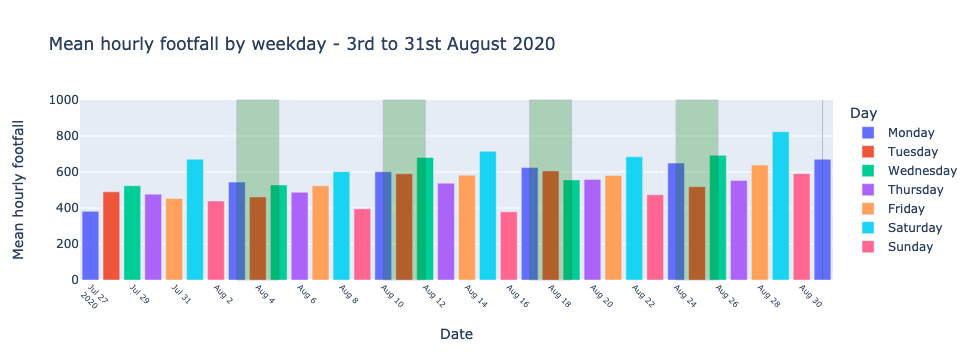

In [12]:
{
    "tags": [
        "hide-input",
    ]
}
data_2020_subset = (footfalldf
        .pipe(start_pipeline)
                 .pipe(remove_new_cameras)
        .pipe(mean_hourly,"day")
        .pipe(reset_df_index)
        .pipe(set_dt_index)
        .pipe(date_range,"2020-07-27","2020-08-31"))

data_2020_subset['Day_Name'] = data_2020_subset.index.day_name()

bar = px.bar(data_2020_subset,y='Count', title="Mean hourly footfall by weekday - 3rd to 31st August 2020",
             color='Day_Name',hover_data=['Day_Name','Count'],
             labels={'Count': 'Mean hourly footfall', 'DateTime': 'Date', 'Day_Name':'Day'})

#Dictionary to store annotation date locations and accompanying text as lists
vrec_anno = {"x0": ['2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31'],
            "x1": ['2020-08-05', '2020-08-12', '2020-08-19', '2020-08-26', '2020-08-31']
                 }

#Loop through 'date' in the annotation dictionary and plot a line with accompanying text on each date.
for i, x0 in enumerate(vrec_anno['x0']):
        bar.add_vrect(
            x0=datetime.datetime.strptime(x0, "%Y-%m-%d").timestamp() * 1000,
            x1=datetime.datetime.strptime(vrec_anno['x1'][i], "%Y-%m-%d").timestamp() * 1000,
            fillcolor='green', opacity=0.25, line_width=1)

bar.update_xaxes(nticks=21,tickangle=45,tickfont=dict(size=8))
bar.update_yaxes(range=[0,1000])

bar.show()

It's difficult to definitively say whether the scheme had an impact on overall footfall during the time it ran.  Generally the Monday and Wednesday of each week appear to have higher footfall rates than other weekdays and there is a noticeable increase from the week before the scheme began, however the same can be said for other weekdays.

What is clear is that footfall continued to climb throughout August and held quite steady, particularly on days were the Eat Out scheme was valid.  Whether this was because of the scheme itself, the weather, further loosening of restrictions or just a combination of these factors isn't certain.

#### Further restrictions

There's an interesting change that occurs around the 21st September 2020.  The chart below shows mean hourly footfall around that time, with some key lockdown dates highlighted.

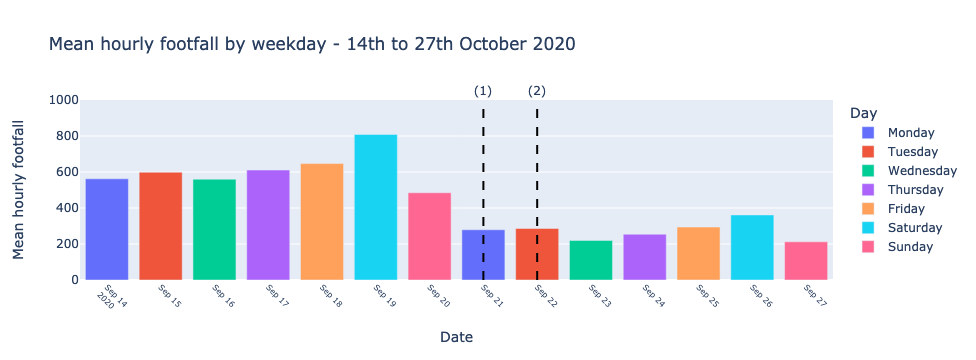

In [13]:
{
    "tags": [
        "hide-input",
    ]
}
data_2020_subset = (footfalldf
        .pipe(start_pipeline)
        .pipe(mean_hourly,"day")
        .pipe(reset_df_index)
        .pipe(set_dt_index)
        .pipe(date_range,"2020-09-14","2020-09-27"))

data_2020_subset['Day_Name'] = data_2020_subset.index.day_name()

bar = px.bar(data_2020_subset,y='Count', title="Mean hourly footfall by weekday - 14th to 27th October 2020",
             color='Day_Name',hover_data=['Day_Name','Count'],
             labels={'Count': 'Mean hourly footfall', 'DateTime': 'Date', 'Day_Name':'Day'})

#Dictionary to store annotation date locations and accompanying text as lists
vline_anno = {'date': ['2020-09-21','2020-09-22'],
              'text': ['(1)','(2)']}

#Loop through 'date' in the annotation dictionary and plot a line with accompanying text on each date.
for i, date in enumerate(vline_anno['date']):
    bar.add_vline(x=datetime.datetime.strptime(date, "%Y-%m-%d").timestamp() * 1000,
              line_color='black',line_dash='dash',
              annotation_position='top',
              annotation=dict(text=vline_anno['text'][i],
                              font_size=12))

bar.update_xaxes(nticks=20,tickangle=45,tickfont=dict(size=8))
bar.update_yaxes(range=[0,1000])

bar.show()

If this isn't a problem with the cameras or related to the weather, then footfall drops quite a lot across the week around the time that the UK Coronavirus alert level is upgraded to 4 on 21st September <b>(1)</b> and further restrictions are announced by the Prime Minister on 22nd September <b>(2)</b>.  It would be interesting to tease out whether these announcements (or anticipation of them) was directly responsible or not.

#### Into Tier 2 and 3

There's a fascinating trend around Leeds going into tier 2 on 14th October, shown in the chart below.

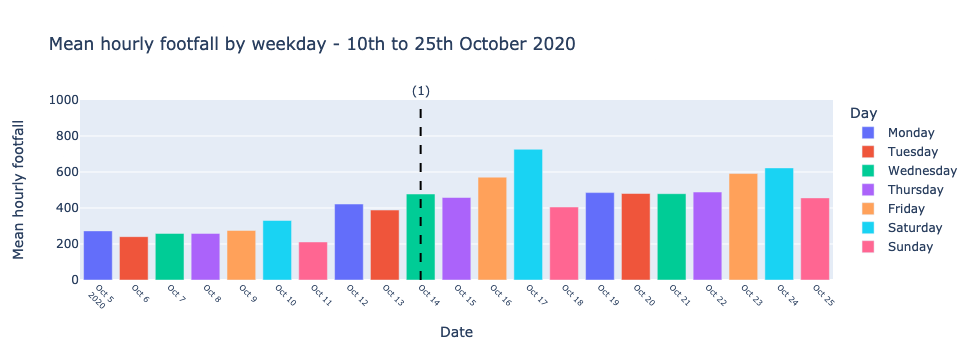

In [14]:
{
    "tags": [
        "hide-input",
    ]
}
data_2020_subset = (footfalldf
        .pipe(start_pipeline)
        .pipe(mean_hourly,"day")
        .pipe(reset_df_index)
        .pipe(set_dt_index)
        .pipe(date_range,"2020-10-05","2020-10-25"))

data_2020_subset['Day_Name'] = data_2020_subset.index.day_name()

bar = px.bar(data_2020_subset,y='Count', title="Mean hourly footfall by weekday - 10th to 25th October 2020",
             color='Day_Name',hover_data=['Day_Name','Count'],
             labels={'Count': 'Mean hourly footfall', 'DateTime': 'Date', 'Day_Name':'Day'})

#Dictionary to store annotation date locations and accompanying text as lists


#Loop through 'date' in the annotation dictionary and plot a line with accompanying text on each date.

bar.add_vline(x=datetime.datetime.strptime('2020-10-14', "%Y-%m-%d").timestamp() * 1000,
              line_color='black',line_dash='dash',
              annotation_position='top',
              annotation=dict(text='(1)',
                              font_size=12))

bar.update_xaxes(nticks=26,tickangle=45,tickfont=dict(size=8))
bar.update_yaxes(range=[0,1000])

bar.show()

Footfall starts to increase in the week commencing 12th October, with the government placing Leeds into tier 2 on 14th October.  This meant restrictions on meeting indoors with the continuing closure of hospitality between 10pm and 5am.  The increase could be interpreted in a number of ways.  It could be a reaction to the ban on mixing indoors as the rule of 6 was in place outdoors.  Perhaps also in anticipation of business closures, people started flocking into the city centre to make the most of supposed freedoms before things got worse.  Were people from other tiers travelling into Leeds whilst it was in a lower tier?

This trend certainly continued later into October and right up to the implementation of the second national lockdown as shown on the chart below.

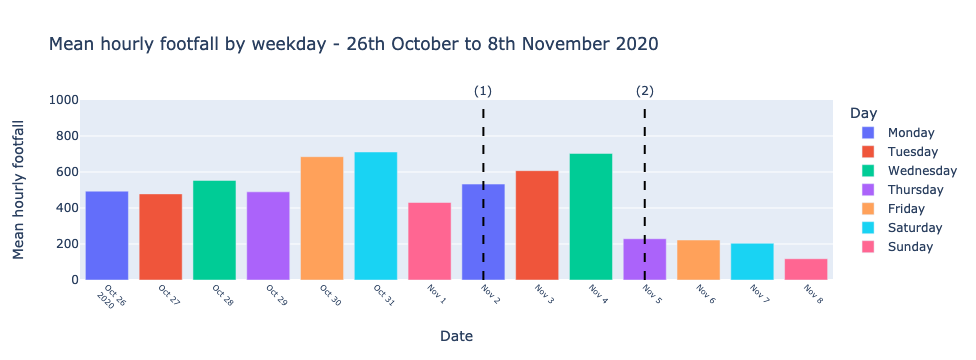

In [15]:
{
    "tags": [
        "hide-input",
    ]
}
data_2020_subset = (footfalldf
        .pipe(start_pipeline)
        .pipe(mean_hourly,"day")
        .pipe(reset_df_index)
        .pipe(set_dt_index)
        .pipe(date_range,"2020-10-26","2020-11-08"))

data_2020_subset['Day_Name'] = data_2020_subset.index.day_name()

bar = px.bar(data_2020_subset,y='Count', title="Mean hourly footfall by weekday - 26th October to 8th November 2020",
             color='Day_Name',hover_data=['Day_Name','Count'],
             labels={'Count': 'Mean hourly footfall', 'DateTime': 'Date', 'Day_Name':'Day'})

#Dictionary to store annotation date locations and accompanying text as lists
vline_anno = {'date': ['2020-11-02','2020-11-05'],
              'text': ['(1)','(2)']}

#Loop through 'date' in the annotation dictionary and plot a line with accompanying text on each date.
for i, date in enumerate(vline_anno['date']):
    bar.add_vline(x=datetime.datetime.strptime(date, "%Y-%m-%d").timestamp() * 1000,
              line_color='black',line_dash='dash',
              annotation_position='top',
              annotation=dict(text=vline_anno['text'][i],
                              font_size=12))

bar.update_xaxes(nticks=26,tickangle=45,tickfont=dict(size=8))
bar.update_yaxes(range=[0,1000])

bar.show()

Leeds is put into tier 3 on 2nd November <b>(1)</b>, a few days before the second national lockdown on 5th November <b>(2)</b>.  Pubs and bars could only open if serving meals.

What this seems to suggest is that the ambient population of Leeds City Centre increased during the tier system due to the ban on indoor gatherings and restrictions on hospitality.  Were people just ignoring the rules and going out on a last shopping spree or pub crawl whilst they still can in anticipation of the new lockdown?

Compared this with the dramatic drop faced when the public were given clear instructions on 5th November to stay at home, that businesses must close and not to travel unless essential.

### Comparison to Google Mobility data

Since the outbreak of the COVID-19 pandemic, Google have made aggregated mobility data available and produced community mobility reports for public health officials to use in their response work.  This covers mobility of Google devices users over several different categories: Retail/Recreation, Grocery/Pharmacy, Parks, Transit Stations, Workplaces and Residential.

Whilst this data are interesting, it's use in estimating ambient population is questionable due to lack of spatial granularity (Whipp et al, 2021)[<sup>2</sup>](#fn2).  Some of the categories follow broadly similar trends to the footfall data when considering key lockdown dates, however it is not possible to identify whether these are related to Leeds City Centre as the dataset covers the entire city region.

Analysis of the data can be found below.

#### Data Import and Preperation

In [16]:
#Reading in the data and combining 2020 and 2021

ukmobility = pd.concat([pd.read_csv("../Data/googlemobility/2020_GB_Region_Mobility_Report.csv"),
                        pd.read_csv("../Data/googlemobility/2021_GB_Region_Mobility_Report.csv")])


#Filter down on West Yorkshire to create a dataframe
westyorkshiremobility = ukmobility.loc[ukmobility.sub_region_1 == "West Yorkshire"]

#Filter down on Leeds to create a dataframe
leedsmobility = westyorkshiremobility.loc[westyorkshiremobility.sub_region_2 == "Leeds District"]

#Set datetime as index
leedsmobility = leedsmobility.set_index('date')
leedsmobility = leedsmobility.loc[ (leedsmobility.index > "2020-03-05") & (leedsmobility.index < "2021-04-26")]

#Slice the dataframe and store the metric column names in a list
measure_keys = leedsmobility.columns[8:].tolist()
#list of strings that will be used to rename measure columns
measure_values = ['retail&rec','grocery&pharm','parks','transit','workplace','residential']

leedsmobility = leedsmobility.rename(columns=dict(zip(measure_keys,measure_values)))
leedsmobility

country_region_code  country_region    sub_region_1  \
date                                                             
2020-03-06                  GB  United Kingdom  West Yorkshire   
2020-03-07                  GB  United Kingdom  West Yorkshire   
2020-03-08                  GB  United Kingdom  West Yorkshire   
2020-03-09                  GB  United Kingdom  West Yorkshire   
2020-03-10                  GB  United Kingdom  West Yorkshire   
...                        ...             ...             ...   
2021-04-21                  GB  United Kingdom  West Yorkshire   
2021-04-22                  GB  United Kingdom  West Yorkshire   
2021-04-23                  GB  United Kingdom  West Yorkshire   
2021-04-24                  GB  United Kingdom  West Yorkshire   
2021-04-25                  GB  United Kingdom  West Yorkshire   

              sub_region_2  metro_area iso_3166_2_code  census_fips_code  \
date                                                                       
2020-03-06  Leeds District         NaN          GB-LDS               NaN   
2020-03-07  Leeds District         NaN          GB-LDS               NaN   
2020-03-08  Leeds District         NaN          GB-LDS               NaN   
2020-03-09  Leeds District         NaN          GB-LDS               NaN   
2020-03-10  Leeds District         NaN          GB-LDS               NaN   
...                    ...         ...             ...               ...   
2021-04-21  Leeds District         NaN          GB-LDS               NaN   
2021-04-22  Leeds District         NaN          GB-LDS               NaN   
2021-04-23  Leeds District         NaN          GB-LDS               NaN   
2021-04-24  Leeds District         NaN          GB-LDS               NaN   
2021-04-25  Leeds District         NaN          GB-LDS               NaN   

                               place_id  retail&rec  grocery&pharm  parks  \
date                                                                        
2020-03-06  ChIJYXT0cPtbeUgRUOJs7Z75DAQ         4.0            5.0   20.0   
2020-03-07  ChIJYXT0cPtbeUgRUOJs7Z75DAQ         6.0            2.0   16.0   
2020-03-08  ChIJYXT0cPtbeUgRUOJs7Z75DAQ        -2.0            2.0    6.0   
2020-03-09  ChIJYXT0cPtbeUgRUOJs7Z75DAQ        -4.0            4.0   -7.0   
2020-03-10  ChIJYXT0cPtbeUgRUOJs7Z75DAQ        -4.0            3.0  -16.0   
...                                 ...         ...            ...    ...   
2021-04-21  ChIJYXT0cPtbeUgRUOJs7Z75DAQ       -35.0            1.0   45.0   
2021-04-22  ChIJYXT0cPtbeUgRUOJs7Z75DAQ       -32.0            3.0  104.0   
2021-04-23  ChIJYXT0cPtbeUgRUOJs7Z75DAQ       -32.0            3.0   88.0   
2021-04-24  ChIJYXT0cPtbeUgRUOJs7Z75DAQ       -36.0            1.0   80.0   
2021-04-25  ChIJYXT0cPtbeUgRUOJs7Z75DAQ       -38.0           -3.0   57.0   

            transit  workplace  residential  
date                                         
2020-03-06      1.0        1.0          0.0  
2020-03-07      7.0        1.0          0.0  
2020-03-08      5.0        2.0         -1.0  
2020-03-09     -5.0        0.0          1.0  
2020-03-10     -6.0        0.0          1.0  
...             ...        ...          ...  
2021-04-21    -51.0      -41.0         13.0  
2021-04-22    -49.0      -39.0         12.0  
2021-04-23    -48.0      -37.0         11.0  
2021-04-24    -38.0      -18.0          5.0  
2021-04-25    -42.0      -17.0          4.0  

[416 rows x 14 columns]

I decided to plot the data using a similar chart format to the high level overview shown earlier, with key lockdown dates highlighted.  The code below generates a chart for each measure of the mobility data except for residential and stores them in a dictionary for plotting later.

In [17]:
#Create an empty dictionary to hold the charts
chart_dict = {}

#Pipeline to create dataframe with calculation of median of period 3rd January to March 5th
data_lockdown = (footfalldf
                 .pipe(start_pipeline)
                 .pipe(set_dt_index)
                 .pipe(set_lockdown_timeframe)
                 .pipe(calculate_baseline))

#For loop to generate a chart for each measure and store it in a dictionary
for i in measure_values:

    fig = make_subplots(specs=[[{'secondary_y': True}]])

    fig.add_trace(
        go.Scatter(x=leedsmobility.index,y=leedsmobility[i],mode='lines',name=i),secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=leedsmobility.index,y=data_lockdown.baseline_per_change,mode='lines',name='Footfall'),secondary_y=True
    )

    fig.update_layout(
        title={'text':"Percent change from baseline - Google Mobility & LCC Footfall",
               'y': 0.9,
               'x':0.5,
               'xanchor':'center',
               'yanchor':'top'},
        font=dict(
            size=10
        )
    # legend=dict(orientation="h",
       # yanchor="top",
       # y=-0.5  ,
       # xanchor="left",
       #x=0.5
   # )
        )
    #Updates various parameters on the x-axis
    fig.update_xaxes(nticks=20, tickangle=45, tickfont=dict(size=8))

    fig.update_yaxes(title_text="Mobility % change",secondary_y=False)
    fig.update_yaxes(title_text="Footfall % change",secondary_y=True)

    #Adds the current chart to the dictionary
    chart_dict.update({i:chart_lockdown_dates(fig)})

data_lockdown

Day_Name   Count  baseline  baseline_change  baseline_per_change
DateTime                                                                     
2020-03-06     Friday  143892    134008             9884             7.375679
2020-03-07   Saturday  163452    151093            12359             8.179730
2020-03-08     Sunday   80772     76505             4267             5.577413
2020-03-09     Monday  112891    110839             2052             1.851334
2020-03-10    Tuesday  103359    110642            -7283            -6.582491
...               ...     ...       ...              ...                  ...
2021-04-21  Wednesday   55981    122765           -66784           -54.399870
2021-04-22   Thursday   56427    118146           -61719           -52.239602
2021-04-23     Friday   64163    134008           -69845           -52.120023
2021-04-24   Saturday   77342    151093           -73751           -48.811659
2021-04-25     Sunday   49863     76505           -26642           -34.823868

[416 rows x 5 columns]

There are several differences in the mobility data compared to LCC footfall.  This is most likely due to the spatial granularity of each dataset.  Footfall is restricted to the city centre cameras whereas mobility data can cover the entire Leeds City region.

Note that as the charts are dual axis, the scales may be different for each line.  Mobility values are on the left and footfall the right.  Where signifiant changes in the scale are present, these will be discussed.

#### Retail and Recreation

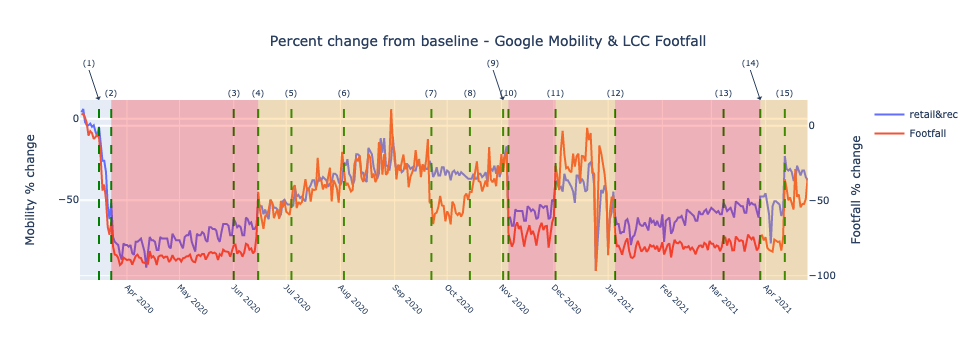

In [18]:
#Plot measure
chart_dict[measure_values[0]].show()

The pattern in the data is similar until after summer when various restrictions are put in place.  For example, footfall drops further from the baseline when work from home, closure of hospitality by 10pm and rule of 6 restrictions are announced, whilst mobility remains stable at summer levels.  This could reflect that people are using more local services rather than enjoying the city centre with advice to stay more local.

For the rest of the year the trend remains strikingly similar, larger drops from baseline reflected in city centre footfall during lockdowns, potentially reflecting the use of more local service, albeit still at a much lower rate than pre-pandemic.

#### Grocery and Pharmacy

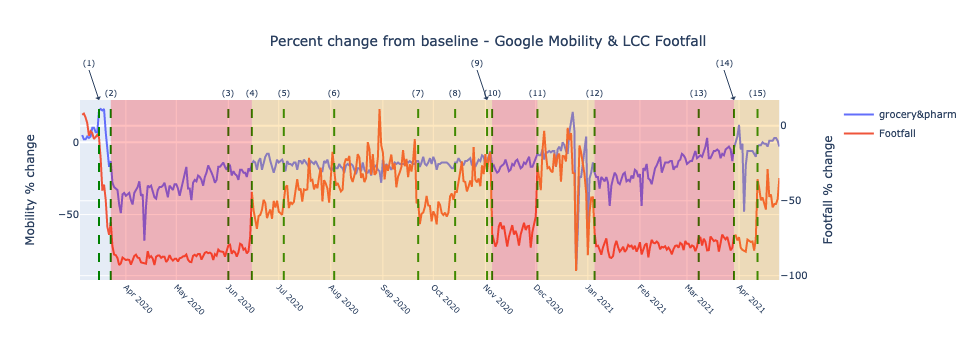

In [19]:
chart_dict[measure_values[1]].show()

Similar trends occur in the grocery and pharmacy data.  Generally the changes are relatively stable over the pandemic, potentially due to the availability of these business as 'essential shops'.  It seems intuitive that people would use local services for essentials and not the city centre, particularly when advised to by government.

#### Parks

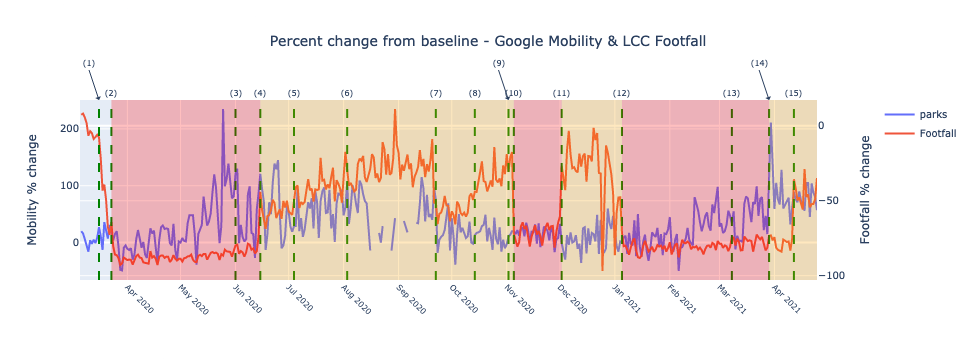

In [20]:
chart_dict[measure_values[2]].show()

The parks data is the most difficult to compare to footfall as the scale is completely different.  For most of the pandemic, parks are visited much more than during baseline.  This could be due to restrictions forcing people to meet more outside in public places, or it could just be down to the baseline being calculated during the winter months.  There are noticable changes in January and February 2021 however, more people seem to be using parks than compared to those months in 2020.

There aren't really any noticable trends when comparing the two.

#### Transit Stations

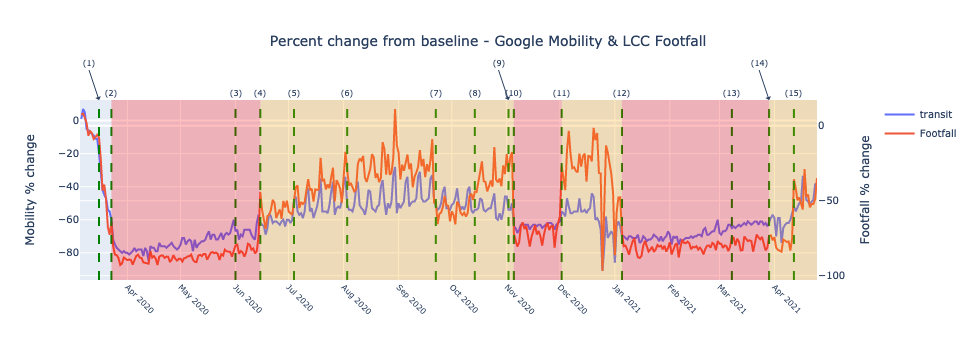

In [21]:
chart_dict[measure_values[3]].show()

Transit stations appears to be the measure that follows footfall trends the closest with a couple of exceptions.  During the introduction and of the initial tier systems in October, city centre footfall rises whilst transit usage remains stable.  This could reflect that people were only allowed to meet outside in public places but discouraged from travelling to other tiers.  For Leeds, this could mean people were generally following advice to not travel outside the city but use services in the centre whilst they still could.

The other is in early December, just after the end of the second lockdown.  The drop in baseline footfall is much lower in the city centre, whilst transit usage is still comparatively lower.  This could show the Christmas shopping period, indicating more people using Leeds specific services rather than travelling to visit people in other places during this time.


### References

<span id="fn1">1: Ross, S. and Breckenridge, G. (2021) COVID for Christmas? Analysing patterns of Christmas mobility in the UK <https://www.cdrc.ac.uk/covid-for-christmas-analysing-patterns-of-christmas-mobility-in-the-uk/></span>

<span id="fn2">2: Whipp, A. et al. (2021) Estimates of the Ambient Population: Assessing the Utility of Conventional and Novel Data Sources. International Journal of Geo-Information. <https://doi.org/10.3390/ijgi10030131></span>
